# Complete Notebook

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from glob import glob

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects

import matplotlib.pyplot as plt
%matplotlib inline 

2021-09-17 18:27:10.589872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Initializing Parameters

In [3]:
IMAGE_SIZE = [380, 380, 3]

train_path = '/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Train'
test_path = '/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Test'
val_path = '/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Val'

## Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory('/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Train',
                                                 target_size = (380, 380),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Test',
                                            target_size = (380, 380),
                                            batch_size = 32,
                                            class_mode = 'categorical')
val_set = test_datagen.flow_from_directory('/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Val',
                                            target_size = (380, 380),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3641 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


## Modified EfficientNetB4

In [5]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-dku3nkc0
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-dku3nkc0
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
     |████████████████████████████████| 50 kB 517 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=0e89d6b1da8ce4c8e253ed542eaf515c6ca7278cc4706e957a0f83d3d45cc7a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwa3145y/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [6]:
import efficientnet.tfkeras as enet

In [7]:
model = enet.EfficientNetB4(include_top=False, input_shape=(380,380,3), pooling='avg', weights='imagenet')

2021-09-17 18:27:31.966361: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 18:27:31.970875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 18:27:32.017541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 18:27:32.018895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 18:27:32.018964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 18:27:32.063188: I tensorflow/stream_executor/platform/def

71892992/71892840 [==============================] - 1s 0us/step


In [8]:
for layer in model.layers:
    layer.trainable = False

## Building Model

In [9]:
class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))


get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [10]:
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

predictions = Dense(2, activation="softmax")(x)

final_model = Model(inputs = model.input, outputs = predictions)

In [11]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [12]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

## Training

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

In [14]:
history = final_model.fit_generator(
    training_set,
    validation_data=val_set,
    epochs=100,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set),
    callbacks=[reduce_lr],
)

2021-09-17 18:27:44.732288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-17 18:27:44.736987: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/100


2021-09-17 18:27:58.249027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-17 18:27:59.241946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-17 18:28:01.267865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


114/114 [==============================] - 331s 3s/step - loss: 0.4344 - accuracy: 0.8052 - val_loss: 0.1866 - val_accuracy: 0.9780
Epoch 2/100
114/114 [==============================] - 218s 2s/step - loss: 0.1452 - accuracy: 0.9574 - val_loss: 0.1092 - val_accuracy: 0.9780
Epoch 3/100
114/114 [==============================] - 217s 2s/step - loss: 0.1039 - accuracy: 0.9678 - val_loss: 0.0685 - val_accuracy: 0.9780
Epoch 4/100
114/114 [==============================] - 217s 2s/step - loss: 0.0969 - accuracy: 0.9703 - val_loss: 0.0489 - val_accuracy: 0.9846
Epoch 5/100
114/114 [==============================] - 213s 2s/step - loss: 0.0870 - accuracy: 0.9676 - val_loss: 0.0441 - val_accuracy: 0.9868
Epoch 6/100
114/114 [==============================] - 214s 2s/step - loss: 0.0823 - accuracy: 0.9731 - val_loss: 0.0419 - val_accuracy: 0.9846
Epoch 7/100
114/114 [==============================] - 215s 2s/step - loss: 0.0727 - accuracy: 0.9792 - val_loss: 0.0373 - val_accuracy: 0.9890
Epoc

## Testing

In [15]:
print("Evaluating on test data ....")
results = final_model.evaluate(test_set, batch_size=32)
print("test loss, test acc:", results)

Evaluating on test data ....
15/15 [==============================] - 38s 3s/step - loss: 0.0166 - accuracy: 0.9934
test loss, test acc: [0.01655673049390316, 0.9934065937995911]


## Plotting 

In [16]:
history.history

{'loss': [0.291031152009964,
  0.13349419832229614,
  0.11302906274795532,
  0.0942038893699646,
  0.08935166895389557,
  0.07172281295061111,
  0.0787348821759224,
  0.07354157418012619,
  0.056078895926475525,
  0.06544264405965805,
  0.0626835823059082,
  0.05716575309634209,
  0.06031982973217964,
  0.06922759115695953,
  0.054260898381471634,
  0.0542595274746418,
  0.06036243587732315,
  0.05821569636464119,
  0.058364979922771454,
  0.05820693448185921,
  0.0419006384909153,
  0.03624117001891136,
  0.05222461000084877,
  0.048464640974998474,
  0.056794315576553345,
  0.04746406897902489,
  0.04075983539223671,
  0.046394553035497665,
  0.04648337513208389,
  0.04981013014912605,
  0.040716752409935,
  0.04290829226374626,
  0.05007664114236832,
  0.0470757856965065,
  0.03964325413107872,
  0.04092784970998764,
  0.03779705986380577,
  0.039032645523548126,
  0.0457003191113472,
  0.036832861602306366,
  0.03955813869833946,
  0.039734624326229095,
  0.03782019019126892,
  0.0

### Accuracy vs Epochs

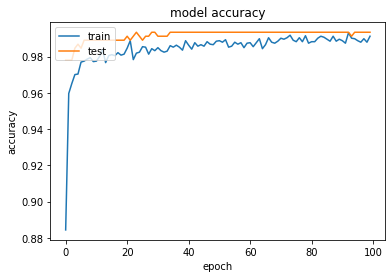

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Loss vs Epochs

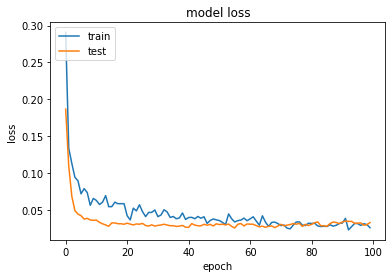

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()